In [103]:
import pandas as pd
import numpy as np
import os, re
import hashlib
import nltk
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from unidecode import unidecode
import itertools
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split

## Import Data from Fake News Dataset powerd by NILC

In [7]:
def returnHash(text):
    return str(hashlib.md5(text[:10].encode('utf-8')).hexdigest())


def returnDataSetFrame():
    dataFrame = pd.DataFrame(columns=[ 'text', 'rawText','label'])
    paths = ['data-normalized/fake/', 'data-normalized/true/']

    for filename in os.listdir(paths[0]):
        with open(paths[0]+filename, 'r') as f:
            text = f.read()
            dataFrame.loc[len(dataFrame)] = [preProcessing(text), removeStopWords(cleaning_text(text)), 'fake']

    for filename in os.listdir(paths[1]):
        with open(paths[1]+filename, 'r') as f:
            text = f.read()
            dataFrame.loc[len(dataFrame)] = [ preProcessing(text), removeStopWords(cleaning_text(text)), 'true']
    return dataFrame

text_data = returnDataSetFrame()    

## Clean Data and Remove StopWords

In [123]:
nltk.download('stopwords')
nltk.download('rslp')

#stopwords = ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 'seu', 'sua', 'ou', 'ser', 'quando', 'muito', 'há', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 'nós', 'tenho', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve', 'houvemos', 'houveram', 'houvera', 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse', 'houvéssemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei', 'houverá', 'houveremos', 'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 'somos', 'são', 'era', 'éramos', 'eram', 'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fôssemos', 'fossem', 'for', 'formos', 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos', 'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tivéramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem', 'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam']

def cleaning_text(text):
    text = text.lower()
    text = re.sub("(\\d|\\W|\d+\w+|\\n)+"," ",text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def stemmerText(text):
    stemmer = nltk.stem.RSLPStemmer()
    words = text.split()
    return ' '.join([stemmer.stem(word) for word in words])

def removeStopWords(text):
    stopwords_nltk = nltk.corpus.stopwords.words('portuguese')
    text = ' '.join([word for word in text.split() if word not in stopwords_nltk])
    #text = ' '.join([word for word in text.split() if word not in stopwords])
    return text

def preProcessing(text):
    return removeStopWords(stemmerText(cleaning_text(text)))

def bagOfWords(text):
    words = text.split()
    counter = Counter(words) 
    return counter.most_common()
    
def cloudOfWords(text, n = 50,title='Bag of Words'):
    word_freq = dict((x, y) for x, y in bagOfWords(text)[:n])
    wordcloud = WordCloud(background_color="white", width=800, height=400)
    wordcloud.generate_from_frequencies(word_freq)
    plt.figure()
    plt.title(title)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /home/ubuntu/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


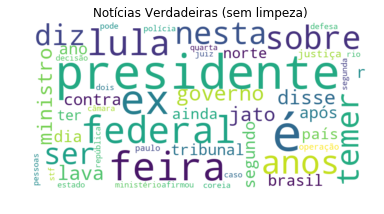

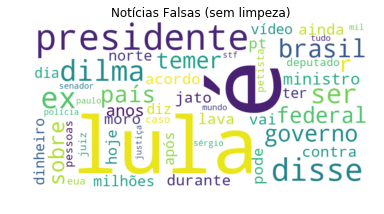

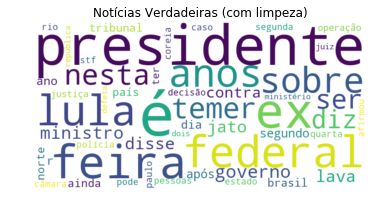

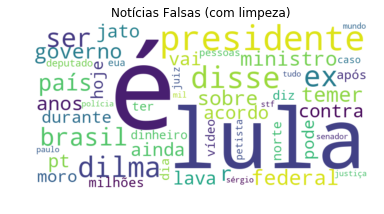

In [124]:
data_true = text_data[text_data.label == 'true'].text.values
data_fake = text_data[text_data.label == 'fake'].text.values

data_raw_true = ' '.join(text_data[text_data.label == 'true']['rawText'])
data_raw_fake = ' '.join(text_data[text_data.label == 'fake']['rawText'])

cloudOfWords(text=data_raw_true, title='Notícias Verdadeiras (sem limpeza)')
cloudOfWords(text=data_raw_fake, title='Notícias Falsas (sem limpeza)')

cloudOfWords(text=cleaning_text(removeStopWords(data_raw_true)), title='Notícias Verdadeiras (com limpeza)')
cloudOfWords(text=cleaning_text(removeStopWords(data_raw_fake)), title='Notícias Falsas (com limpeza)')

## Visualize Data with wordclouds and the most frequency words

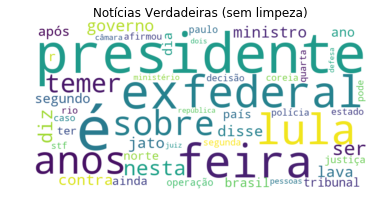

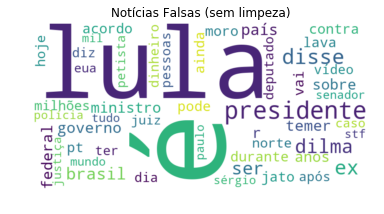

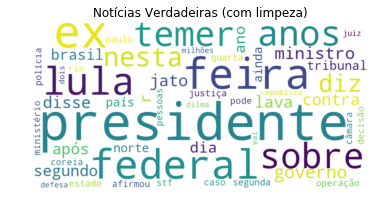

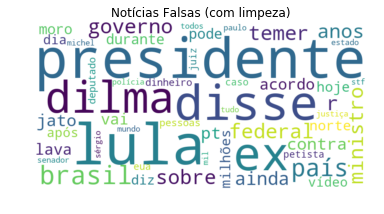

In [114]:
data_true = text_data[text_data.label == 'true'].text.values
data_fake = text_data[text_data.label == 'fake'].text.values

data_raw_true = ' '.join(text_data[text_data.label == 'true']['rawText'])
data_raw_fake = ' '.join(text_data[text_data.label == 'fake']['rawText'])

cloudOfWords(text=data_raw_true, title='Notícias Verdadeiras (sem limpeza)')
cloudOfWords(text=data_raw_fake, title='Notícias Falsas (sem limpeza)')

cloudOfWords(text=cleaning_text(removeStopWords(data_raw_true)), title='Notícias Verdadeiras (com limpeza)')
cloudOfWords(text=cleaning_text(removeStopWords(data_raw_fake)), title='Notícias Falsas (com limpeza)')

Número total de palavras: 827056


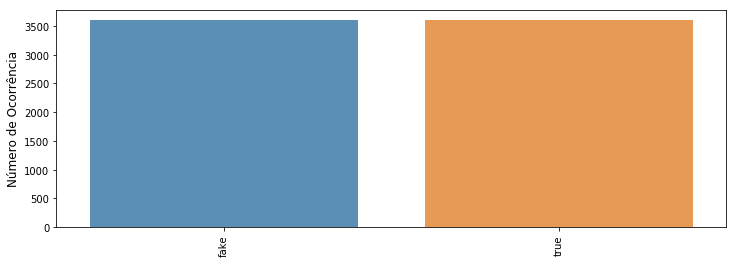

In [118]:
print("Número total de palavras: " + str(text_data['text'].apply(lambda x: len(x.split(' '))).sum()))

label_plot = text_data['label'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(label_plot.index, label_plot.values, alpha=0.8)
plt.ylabel('Número de Ocorrência', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation=90)
plt.show();

## TF-IDF

In [25]:
vectorizer = TfidfVectorizer(max_df=0.85)

data = text_data.sample(frac=1)
text = data['rawText']
label = data['label'].rank(method='dense', ascending=False).astype(int)

data_train = vectorizer.fit_transform(text)

---- Scores ----
[0.89855072 0.91304348 0.89233954 0.86335404 0.89211618 0.90248963
 0.91078838 0.91286307 0.89834025 0.906639  ]
              precision    recall  f1-score   support

           1       0.88      0.89      0.88      1200
           2       0.89      0.87      0.88      1176

   micro avg       0.88      0.88      0.88      2376
   macro avg       0.88      0.88      0.88      2376
weighted avg       0.88      0.88      0.88      2376



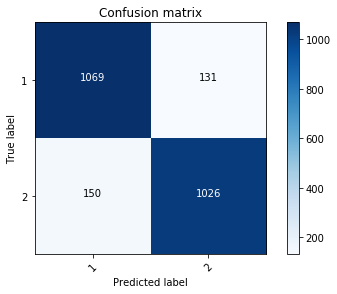

In [131]:
vectorizer = TfidfVectorizer(max_df=0.85)

data = text_data.sample(frac=1)
text = data['text']
label = data['label'].rank(method='dense', ascending=False).astype(int)

data_train = vectorizer.fit_transform(text)

x_train, x_test, y_train, y_test = train_test_split(text, label, test_size=0.33, random_state=42)

x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.fit_transform(x_test)

neural_classifier = MLPClassifier(hidden_layer_sizes=(5,12),activation='tanh',solver='lbfgs',random_state=1)
scores_neural = cross_val_score(neural_classifier, x_train, y_train, cv=10)
Y_pred = cross_val_predict(neural_classifier,x_test,y_test, cv=10)
conf_mat = confusion_matrix(y_test,Y_pred)
print("---- Scores ----")
print(scores_neural)
print(classification_report(y_test, Y_pred))
plot_confusion_matrix(conf_mat, classes=[1, 2],title='Confusion matrix')